In [29]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from PATHS import HOME, DATASET_PATH, ANIME_DATASET_2023, DATA_PREPROCESSING

In [2]:
print('HOME', HOME)
print('DATASET FOLDER', DATASET_PATH)
print('ANIME DATASET 2023', ANIME_DATASET_2023)
print('DATA PREPROCESSING', DATA_PREPROCESSING)

HOME d:\Data Science Programming\Project
DATASET FOLDER d:\Data Science Programming\Project\raw_animes_dataset
ANIME DATASET 2023 d:\Data Science Programming\Project\raw_animes_dataset\anime-dataset-2023.csv
DATA PREPROCESSING d:\Data Science Programming\Project\Data Preprocessing


In [3]:
anime_clean_df = pd.read_csv(os.path.join(DATA_PREPROCESSING, 'anime-data-preprocessing.csv'))
anime_clean_df.head()

,Name,Score,Genres,Synopsis,Type,Episodes,Producers,Studios,Source,Time per ep (Min),Rating,Rank,Popularity,Favorites,Scored By,Members,Released date,Completed date
0,Fullmetal Alchemist: Brotherhood,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,64.0,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24.0,R - 17+ (violence & profanity),1,3,217606,2020030,3176556,2009-04-05,2010-07-04
1,Steins;Gate,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,24.0,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24.0,PG-13 - Teens 13 or older,2,13,182964,1336233,2440369,2011-04-06,2011-09-14
2,Bleach: Sennen Kessen-hen,9.07,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,13.0,"TV Tokyo, Aniplex, Dentsu, Shueisha",Pierrot,Manga,24.0,R - 17+ (violence & profanity),3,464,17999,213872,445198,2022-10-11,2022-12-27
3,Gintama°,9.06,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,51.0,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,24.0,PG-13 - Teens 13 or older,4,331,15947,237957,595767,2015-04-08,2016-03-30
4,Shingeki no Kyojin Season 3 Part 2,9.05,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,10.0,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23.0,R - 17+ (violence & profanity),5,24,55245,1471825,2104016,2019-04-29,2019-07-01


### Check UNKNOWN in RATING column

In [8]:
unknown_rating_count = anime_clean_df[anime_clean_df['Rating']=='UNKNOWN']
unknown_rating_count

,Name,Score,Genres,Synopsis,Type,Episodes,Producers,Studios,Source,Time per ep (Min),Rating,Rank,Popularity,Favorites,Scored By,Members,Released date,Completed date
2365,Dotto Koni-chan,7.34,Comedy,Koni (whose character is based on the famous S...,TV,26.0,"Genco, Animax",Shaft,Original,25.0,UNKNOWN,2366,8372,22,1693,4439,2000-11-26,2001-05-29
2670,Xue Ying Ling Zhu 2nd Season,7.28,"Action, Adventure, Fantasy, Romance",The second season of Xue Ying Ling Zhu.,ONA,22.0,Tencent Penguin Pictures,Mili Pictures,Novel,18.0,UNKNOWN,2671,10273,10,1040,2273,2020-12-31,2021-03-04
3572,RPG Densetsu Hepoi,7.11,"Adventure, Fantasy","The adventure of Hepoi, a hero of heporis, Ryu...",TV,50.0,Nihon Ad Systems,Gallop,Unknown,25.0,UNKNOWN,3573,12871,10,253,928,1990-10-06,1991-09-28
3615,Sayonara Watashi no Cramer Movie: First Touch,7.10,"Romance, Sports",14-year-old Nozomi Onda has only one thing on ...,Movie,1.0,UNKNOWN,LIDENFILMS,Manga,104.0,UNKNOWN,3616,5969,18,3531,10309,2021-06-11,2021-06-11
3876,Oi! Ryouma,7.05,"Adventure, Drama","In the middle of the 19th century, Japan was s...",TV,39.0,UNKNOWN,Animation 21,Manga,25.0,UNKNOWN,3877,13475,1,188,779,1992-04-07,1993-03-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13132,Brave Fire S0.9,4.98,Sci-Fi,This work was submitted in a special animation...,Special,1.0,Tezuka Productions,UNKNOWN,Unknown,6.0,UNKNOWN,13133,14237,1,162,606,1987-04-29,1987-04-29
13540,Rebirth Moon Divergence,4.66,"Action, Fantasy","Ires and his father, Leglight are peddlers. Ne...",OVA,1.0,Idea Factory,UNKNOWN,Game,17.0,UNKNOWN,13541,13556,0,205,759,2005-11-23,2005-11-23
13541,Mechano: Scientific Attack Force,4.66,"Avant Garde, Comedy, Fantasy, Horror",Three 10-minute videos present a trippy view i...,OVA,3.0,UNKNOWN,UNKNOWN,Unknown,10.0,UNKNOWN,13542,14505,1,179,561,1995-09-01,1995-09-01
13728,Chou Futsuu Toshi Kashiwa Densetsu R,4.39,"Comedy, Fantasy","A gag anime set in Kashiwa, featuring high sch...",TV,10.0,UNKNOWN,Super Normal Studio,Other,5.0,UNKNOWN,13729,8217,3,712,4703,2020-07-06,2020-09-28


# Split into train and test files
- The train file has Rating is not equal UNKNOWN
- The test file is remain

In [15]:
known_rating_df = anime_clean_df[anime_clean_df['Rating'] != 'UNKNOWN']
unknown_rating_df = anime_clean_df[anime_clean_df['Rating'] == 'UNKNOWN']

feature_train_df = known_rating_df.drop(columns=['Rating'])
rating_train_df = known_rating_df['Rating']

feature_test_df = unknown_rating_df.drop(columns=['Rating'])
label_test_df = unknown_rating_df['Rating']

### Visuallize distribution of rating in train dataset

In [25]:
def visualize(y):

    counts = []
    labels = []

    unique_quality = np.sort(np.unique(y))
    for quality in unique_quality:
        labels.append(quality)

        quality_count = (y==quality).sum()
        counts.append(quality_count)

    colors = plt.cm.get_cmap('tab10', len(unique_quality))

    # Plot the data
    bars = plt.bar(labels, counts, color=colors(range(len(unique_quality))))
    plt.title("Distribution of anime's rating")
    plt.ylabel('Count')
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05,  # Position above the bar
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.show()


C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_20696\2982871135.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_quality))


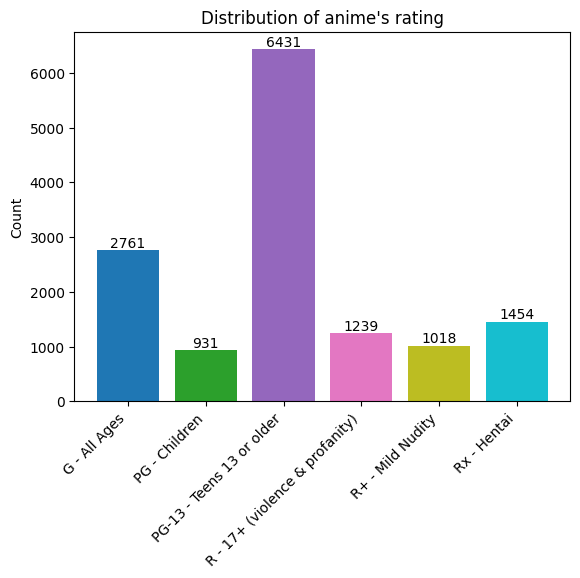

In [26]:
visualize(rating_train_df.values)

### Normalize string columns to numeric vector

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,  # Giới hạn số đặc trưng để tránh quá tải
    stop_words='english',  # Loại bỏ stopwords
    ngram_range=(1, 2)  # Sử dụng cả đơn ngữ và song ngữ
)



In [28]:
correlation_matrix = anime_clean_df.corr()

# Vẽ heatmap để kiểm tra tương quan giữa các đặc trưng và nhãn
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

ValueError: could not convert string to float: 'Fullmetal Alchemist: Brotherhood'